In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/DL/NaturalImagesDataset.zip > out.txt

In [4]:
!ls

drive  __MACOSX  out.txt  sample_data  test  train  val


In [5]:
!mkdir data
!mv train data
!mv val data
!mv test data

In [6]:
!ls
!ls data
!ls data/test
!ls data/test/airplane

data  drive  __MACOSX  out.txt	sample_data
test  train  val
airplane  car  cat  dog  flower  fruit	motorbike  person
airplane_0005.jpg  airplane_0132.jpg  airplane_0293.jpg  airplane_0486.jpg
airplane_0008.jpg  airplane_0135.jpg  airplane_0308.jpg  airplane_0494.jpg
airplane_0013.jpg  airplane_0136.jpg  airplane_0337.jpg  airplane_0527.jpg
airplane_0025.jpg  airplane_0157.jpg  airplane_0349.jpg  airplane_0536.jpg
airplane_0027.jpg  airplane_0159.jpg  airplane_0358.jpg  airplane_0539.jpg
airplane_0031.jpg  airplane_0170.jpg  airplane_0362.jpg  airplane_0542.jpg
airplane_0051.jpg  airplane_0182.jpg  airplane_0375.jpg  airplane_0550.jpg
airplane_0058.jpg  airplane_0188.jpg  airplane_0380.jpg  airplane_0558.jpg
airplane_0064.jpg  airplane_0208.jpg  airplane_0384.jpg  airplane_0560.jpg
airplane_0069.jpg  airplane_0213.jpg  airplane_0406.jpg  airplane_0565.jpg
airplane_0075.jpg  airplane_0237.jpg  airplane_0418.jpg  airplane_0584.jpg
airplane_0079.jpg  airplane_0259.jpg  airplane_0419.jpg  a

In [7]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from PIL import Image
import torchvision.models as models

# GoogLeNet

source: https://hackmd.io/@bouteille/Bk-61Fo8U

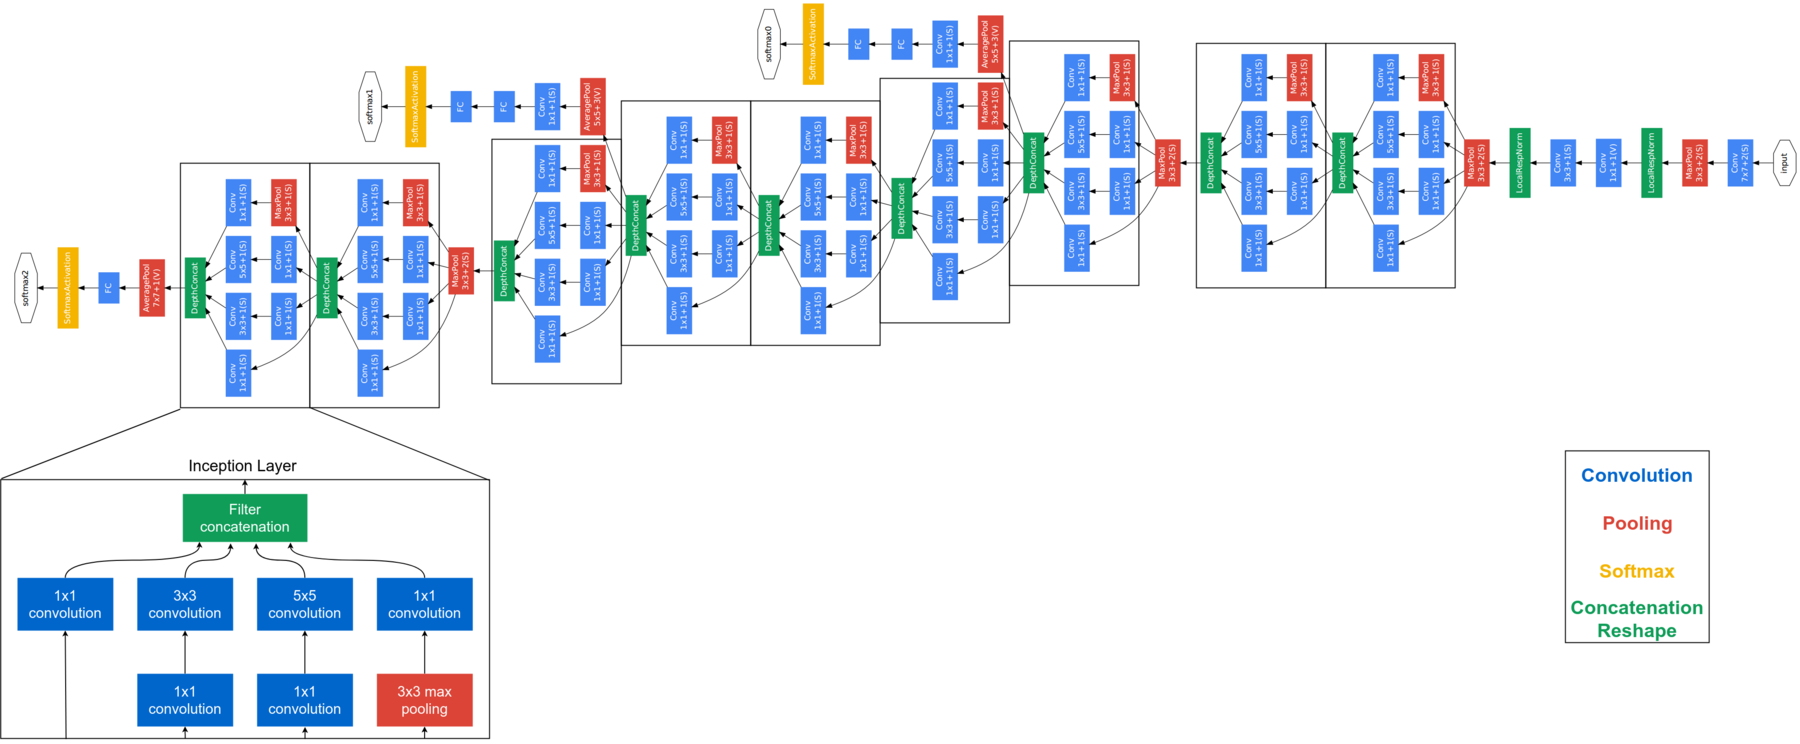

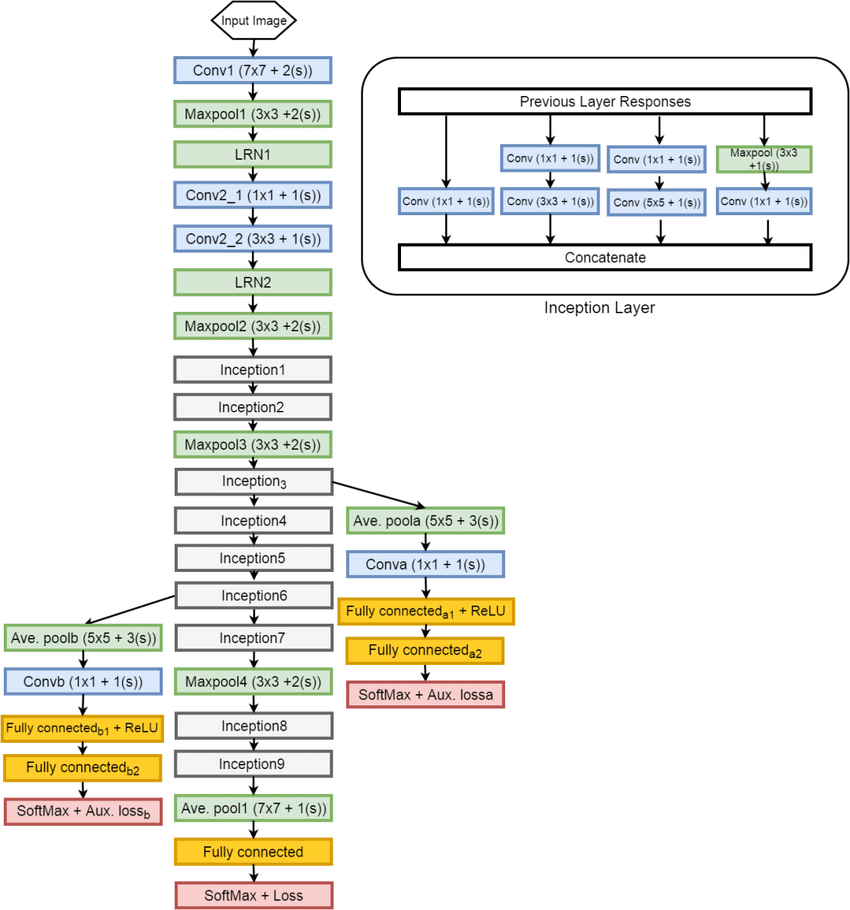

In [19]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [20]:
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pp):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, f_3x3_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_3x3_r, f_3x3, kernel_size=3, stride=1, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, f_5x5_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_5x5_r, f_5x5, kernel_size=5, stride=1, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1, ceil_mode=True),
            ConvBlock(in_channels, f_pp, kernel_size=1, stride=1, padding=0)
        )
        
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        return torch.cat([branch1, branch2, branch3, branch4], 1)

In [21]:
class InceptionAux(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(2048, 1024)
        # self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.pool(x)
        
        x = self.conv(x)
        x = self.act(x)
    
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.act(x)
        # x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [22]:
class GoogLeNet(nn.Module):
    
    def __init__(self, num_classes):
        super(GoogLeNet, self).__init__()
      
        self.conv1 = ConvBlock(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = ConvBlock(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception3A = InceptionModule(in_channels=192,
                                           f_1x1=64,
                                           f_3x3_r=96,
                                           f_3x3=128,
                                           f_5x5_r=16,
                                           f_5x5=32,
                                           f_pp=32)
        self.inception3B = InceptionModule(in_channels=256,
                                           f_1x1=128,
                                           f_3x3_r=128,
                                           f_3x3=192,
                                           f_5x5_r=32,
                                           f_5x5=96,
                                           f_pp=64)
        self.pool4 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception4A = InceptionModule(in_channels=480,
                                           f_1x1=192,
                                           f_3x3_r=96,
                                           f_3x3=208,
                                           f_5x5_r=16,
                                           f_5x5=48,
                                           f_pp=64)
        self.inception4B = InceptionModule(in_channels=512,
                                           f_1x1=160,
                                           f_3x3_r=112,
                                           f_3x3=224,
                                           f_5x5_r=24,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4C = InceptionModule(in_channels=512,
                                           f_1x1=128,
                                           f_3x3_r=128,
                                           f_3x3=256,
                                           f_5x5_r=24,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4D = InceptionModule(in_channels=512,
                                           f_1x1=112,
                                           f_3x3_r=144,
                                           f_3x3=288,
                                           f_5x5_r=32,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4E = InceptionModule(in_channels=528,
                                           f_1x1=256,
                                           f_3x3_r=160,
                                           f_3x3=320,
                                           f_5x5_r=32,
                                           f_5x5=128,
                                           f_pp=128)
        self.pool5 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception5A = InceptionModule(in_channels=832,
                                           f_1x1=256,
                                           f_3x3_r=160,
                                           f_3x3=320,
                                           f_5x5_r=32,
                                           f_5x5=128,
                                           f_pp=128)
        self.inception5B = InceptionModule(in_channels=832,
                                           f_1x1=384,
                                           f_3x3_r=192,
                                           f_3x3=384,
                                           f_5x5_r=48,
                                           f_5x5=128,
                                           f_pp=128)
        self.pool6 = nn.AdaptiveAvgPool2d((1,1))
        # self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        
        self.aux4A = InceptionAux(512, num_classes) 
        self.aux4D = InceptionAux(528, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.inception3A(x)
        x = self.inception3B(x)
        x = self.pool4(x)
        x = self.inception4A(x)
  
        aux1 = self.aux4A(x)
        
        x = self.inception4B(x)
        x = self.inception4C(x)
        x = self.inception4D(x)
  
        aux2 = self.aux4D(x)
        
        x = self.inception4E(x)
        x = self.pool5(x)
        x = self.inception5A(x)
        x = self.inception5B(x)
        x = self.pool6(x)
        x = torch.flatten(x,1)
        # x = self.dropout(x)
        x = self.fc(x)
        
        return x, aux1, aux2

In [23]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((227, 227)),
    # torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomVerticalFlip(),
    # torchvision.transforms.RandomPerspective(distortion_scale=0.2),
    # torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=0, std=1),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((227, 227)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=0, std=1),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((227, 227)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=0, std=1),
])

train_dataset = torchvision.datasets.ImageFolder(root='data/train', transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root='data/val', transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root='data/test', transform=test_transforms)

0


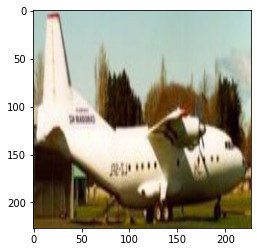

In [24]:
image = train_dataset[3][0].permute(1, 2, 0)
print(train_dataset[3][1])
plt.imshow(image)
plt.show()

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(F.log_softmax(outputs, dim=1), dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
  
def predicts(outputs):
    _, preds = torch.max(F.log_softmax(outputs, dim=1), dim=1)
    return preds
  
criterion = torch.nn.CrossEntropyLoss()

In [26]:
def train(model, batch, optimizer):
    model.train()
    optimizer.zero_grad()
    inputs, labels = batch
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs, aux1, aux2 = model(inputs)
    l = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
    l.backward()
    optimizer.step()
    return l


def evaluate(model, batch, optimizer):
    model.eval()
    inputs, labels = batch
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs, _, _ = model(inputs)
    a = accuracy(outputs, labels)
    l = criterion(outputs, labels)
    return a, l

In [27]:
model = GoogLeNet(8)
model.cuda()

GoogLeNet(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): ConvBlock(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3A): InceptionModule(
    (branch1): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentu

In [28]:
LEARNING_RATE = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
epoches = 100

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100)

for epoch in range(epoches):
    print('Epoch:', epoch + 1)
    c = 0
    for batch in train_loader:
        l = train(model, batch, optimizer)
        c += len(batch[0])
        print("[%d/%d] Loss: %.2f" % (c, len(train_dataset), l.item()))
      
    for batch in train_loader:
        a, l = evaluate(model, batch, optimizer)
        print("Train Loss: %.2f, Train Accuracy: %.2f" % (l.item(), a.item()))
        break

    acc = 0
    loo = 0
    d = 0
    for batch in val_loader:
        a, l = evaluate(model, batch, optimizer)
        acc += a.item()
        loo += l.item()
        d += 1
    print("Val Loss: %.2f, Val Accuracy: %.2f" % (loo / d, acc / d))
    
    torch.save(model.state_dict(), 'drive/MyDrive/DL/alexnet.pt')

Epoch: 1
[100/5519] Loss: 3.36
[200/5519] Loss: 3.22
[300/5519] Loss: 3.07
[400/5519] Loss: 2.97
[500/5519] Loss: 2.89
[600/5519] Loss: 2.93
[700/5519] Loss: 2.81
[800/5519] Loss: 2.64
[900/5519] Loss: 2.65
[1000/5519] Loss: 2.60
[1100/5519] Loss: 2.54
[1200/5519] Loss: 2.53
[1300/5519] Loss: 2.48
[1400/5519] Loss: 2.25
[1500/5519] Loss: 2.30
[1600/5519] Loss: 2.33
[1700/5519] Loss: 2.02
[1800/5519] Loss: 2.04
[1900/5519] Loss: 2.13
[2000/5519] Loss: 1.90
[2100/5519] Loss: 1.90
[2200/5519] Loss: 2.02
[2300/5519] Loss: 1.93
[2400/5519] Loss: 1.93
[2500/5519] Loss: 1.88
[2600/5519] Loss: 1.84
[2700/5519] Loss: 1.70
[2800/5519] Loss: 1.63
[2900/5519] Loss: 1.55
[3000/5519] Loss: 1.59
[3100/5519] Loss: 1.51
[3200/5519] Loss: 1.69
[3300/5519] Loss: 1.60
[3400/5519] Loss: 1.51
[3500/5519] Loss: 1.64
[3600/5519] Loss: 1.36
[3700/5519] Loss: 1.30
[3800/5519] Loss: 1.46
[3900/5519] Loss: 1.32
[4000/5519] Loss: 1.16
[4100/5519] Loss: 1.51
[4200/5519] Loss: 1.42
[4300/5519] Loss: 1.29
[4400/5519]

KeyboardInterrupt: ignored

In [ ]:
def info(item):
    input = item[0]
    input = input.cuda()
    output = model(input.unsqueeze(0))
    print("Output: %s" % output.argmax(dim=1).item(), "Expected: %s" % item[1])

In [ ]:
for x in test_dataset:
    info(x)

Output: 0 Expected: 0
Output: 4 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 2 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 3 Expected: 0
Output: 3 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 